In [14]:
%load_ext autoreload
%autoreload 2

In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

In [3]:
sampler_source = MixtureNormalSampler([0], 1,  0.5, batch_size=256)
sampler_target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=256)

In [4]:
source = sampler_source(jax.random.PRNGKey(0))
target = sampler_target(jax.random.PRNGKey(0))

In [5]:
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from ott.geometry.pointcloud import PointCloud

In [6]:
source=source.sort(axis=0)
target =target.sort(axis=0)

In [7]:
geom = PointCloud(source, target, epsilon=1e-5)

In [8]:
sinkhorn_output = sinkhorn.Sinkhorn()(
            linear_problem.LinearProblem(geom)
        )

In [9]:
import pandas as pd
from entot.models.utils import _concatenate
pi_star_inds = jax.random.categorical(jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output.matrix.flatten()), shape=(len(source),))
inds_source = pi_star_inds // len(target)
inds_target = pi_star_inds % len(target)
data = _concatenate(source[inds_source], target[inds_target])
gt = pd.DataFrame(data = data, columns=["source", "target"])

<Axes: xlabel='source', ylabel='target'>

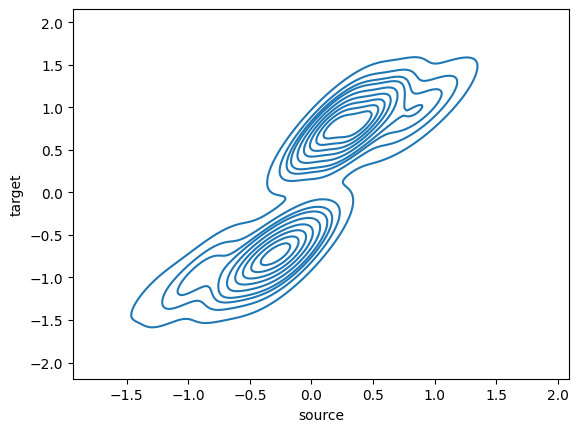

In [10]:
import seaborn as sns
sns.kdeplot(gt, x="source", y="target")

In [11]:
kg = KantorovichGapModel(epsilon=1e-3, input_dim=[1], callback=plot_1D, k_noise_per_x=1, iterations=1000, callback_iters=100)

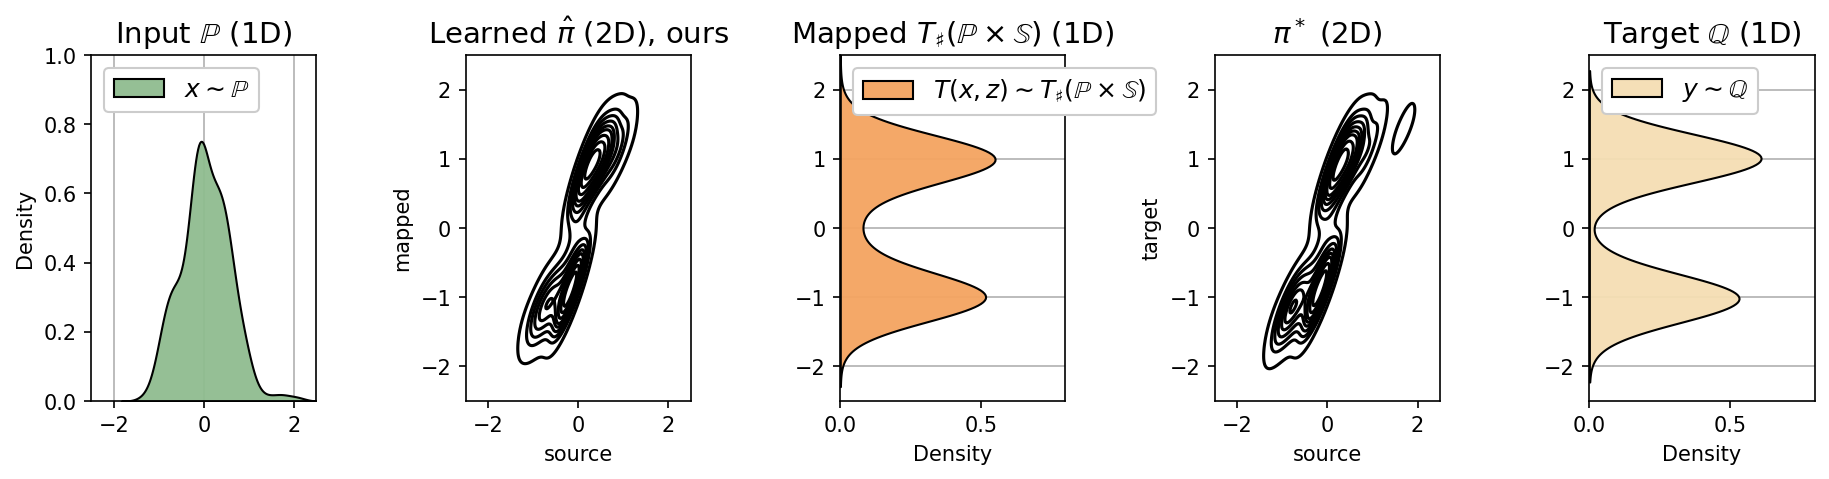

100%|██████████| 1000/1000 [30:41<00:00,  1.84s/it]


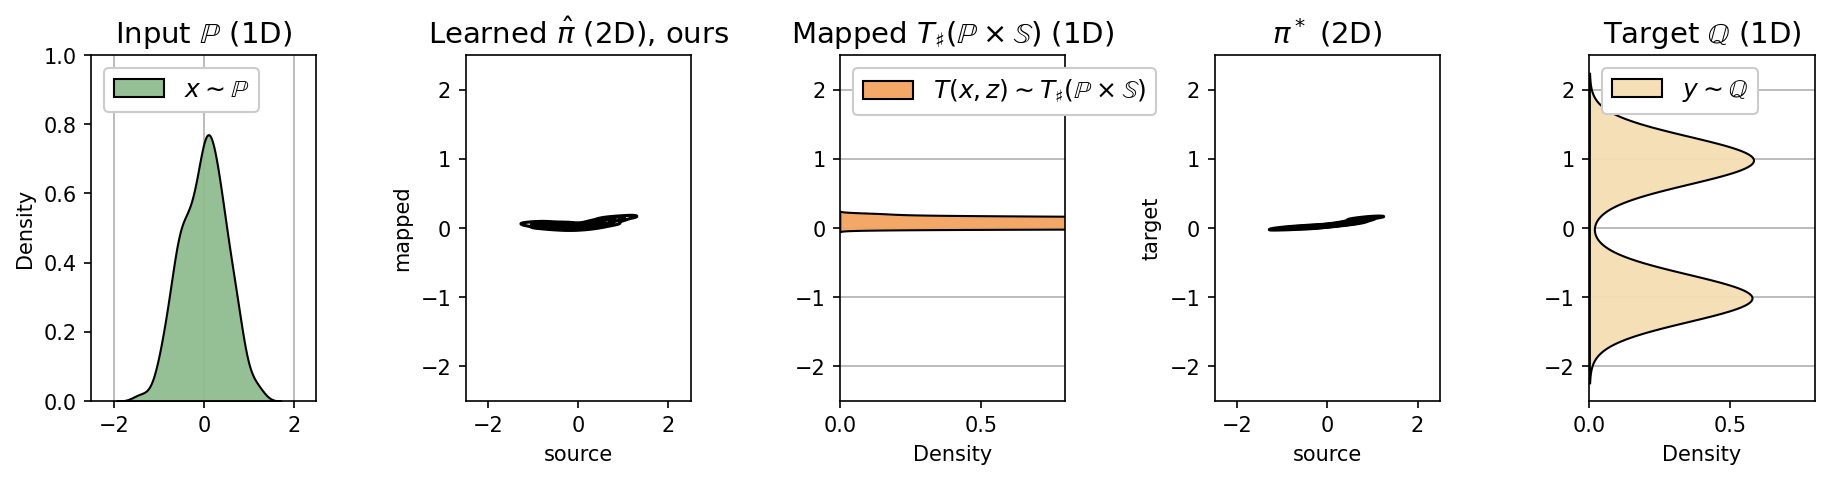

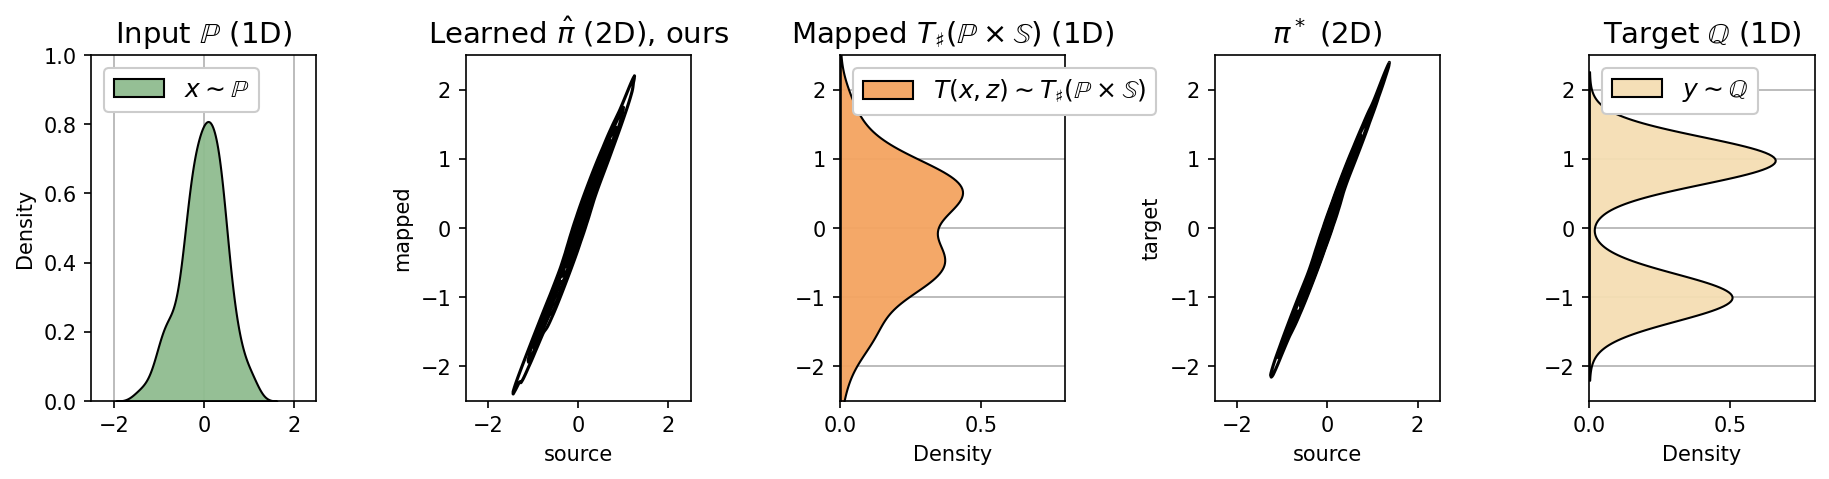

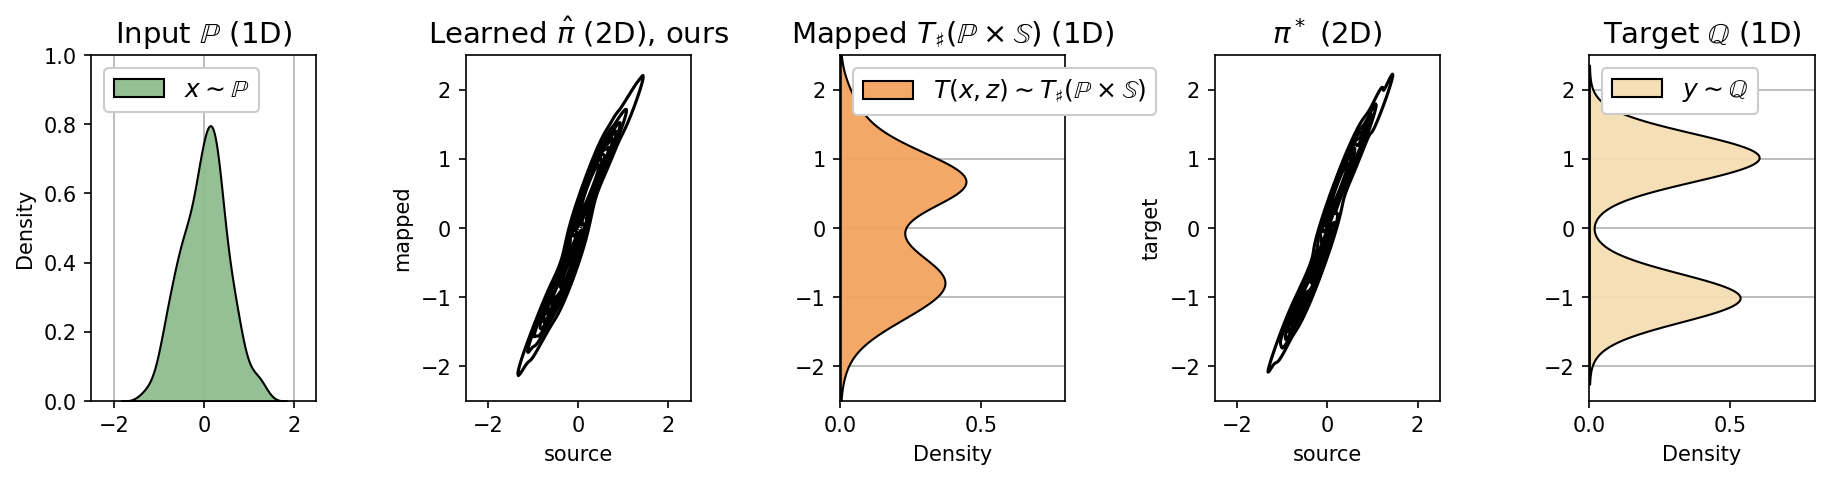

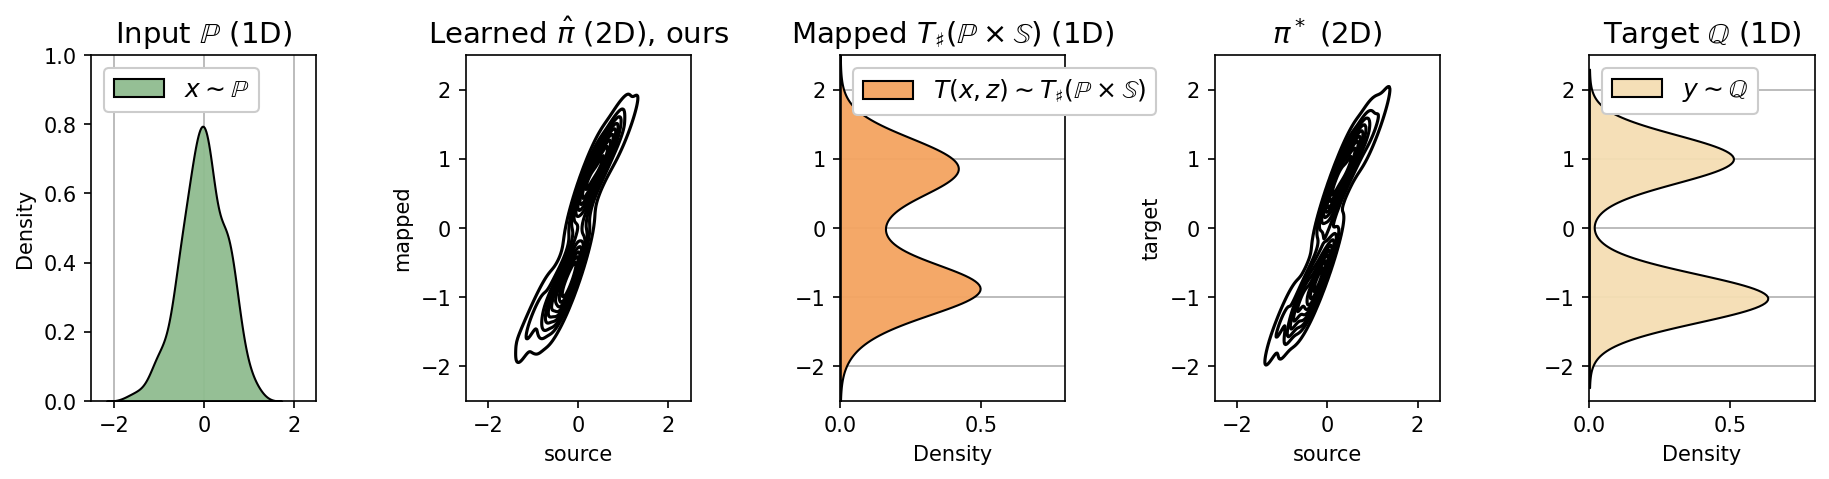

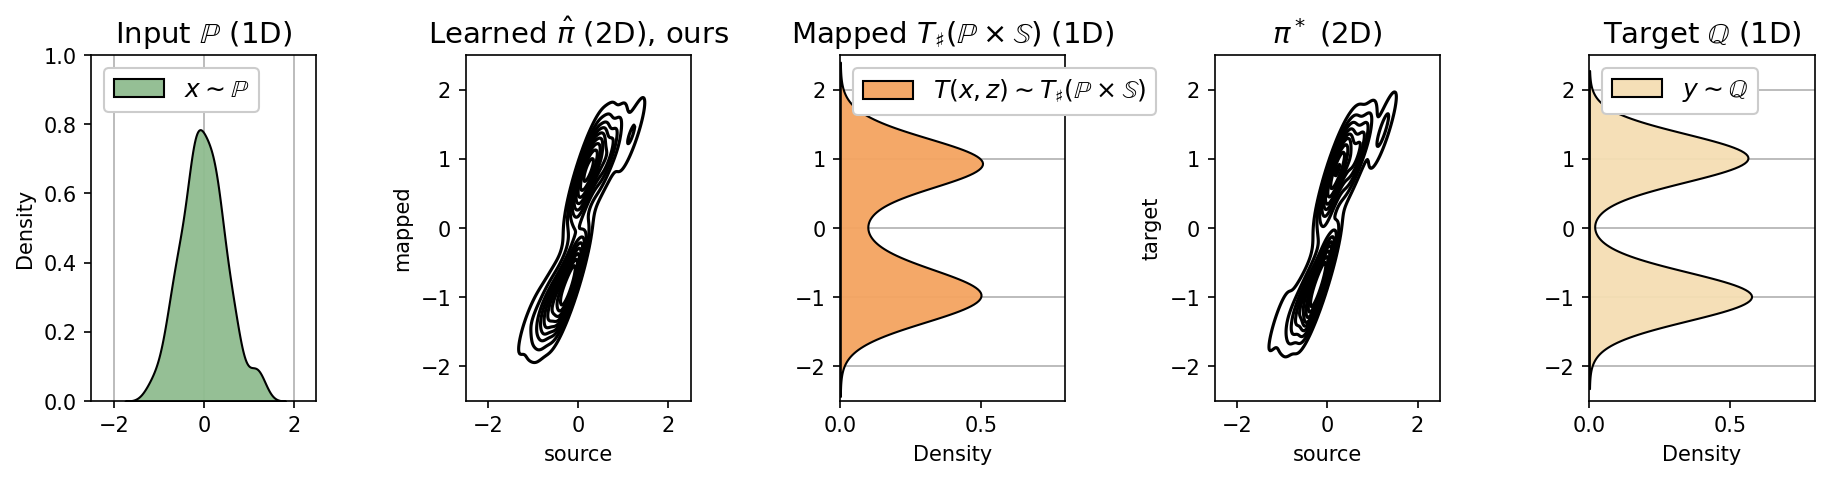

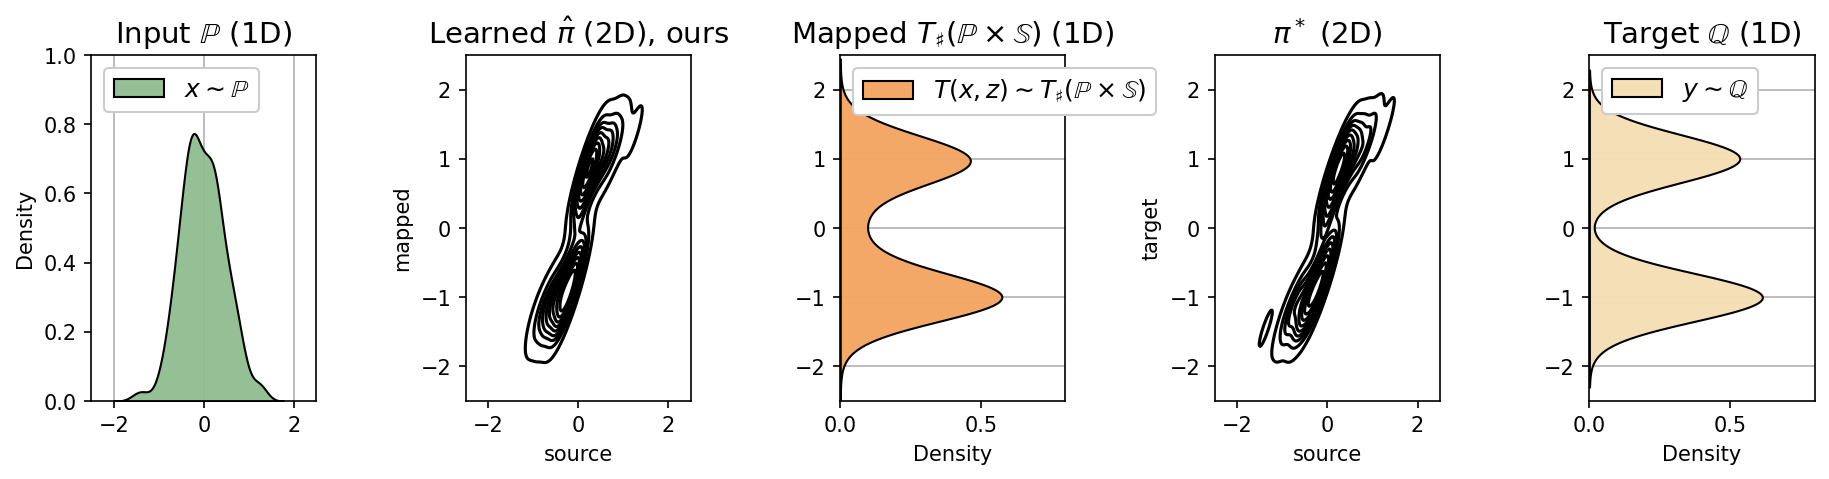

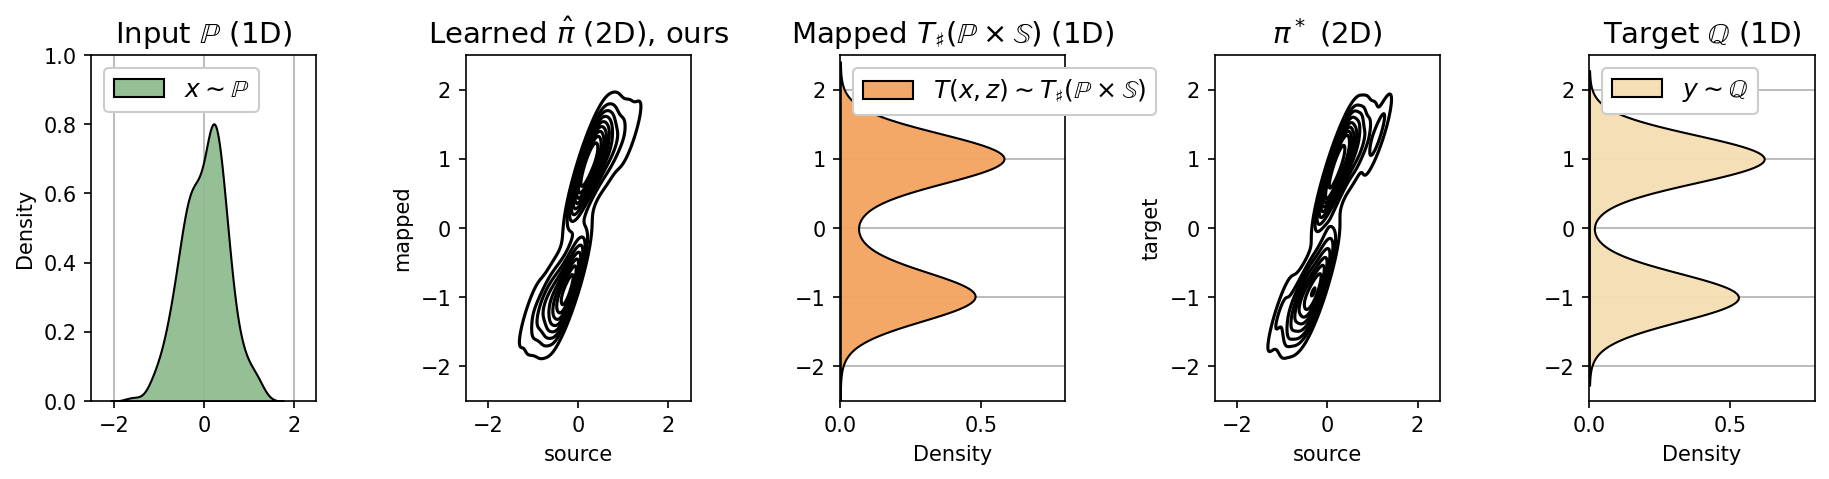

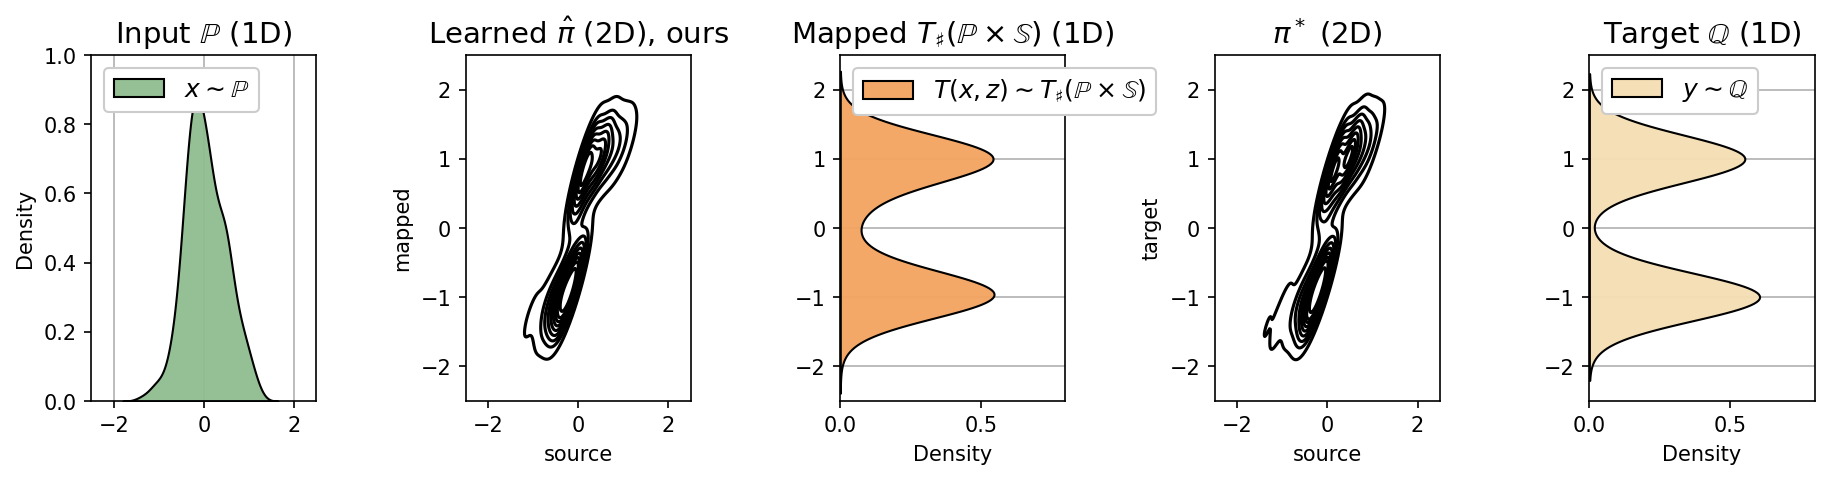

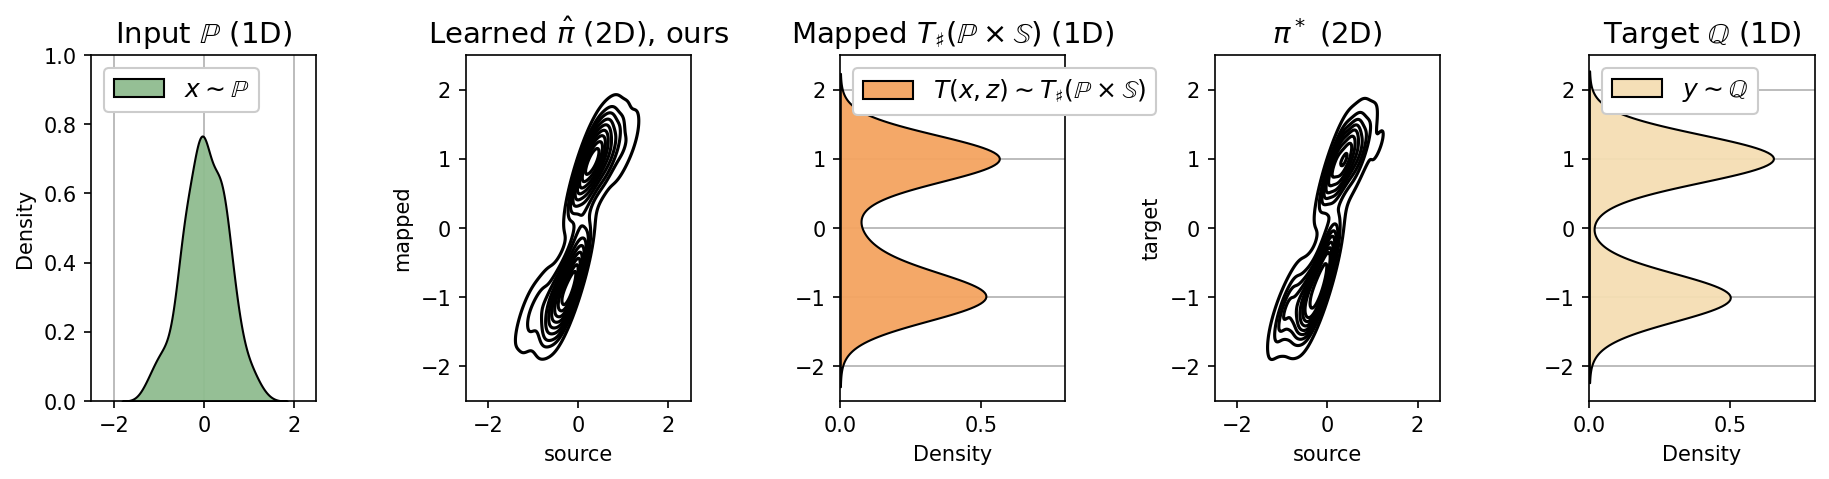

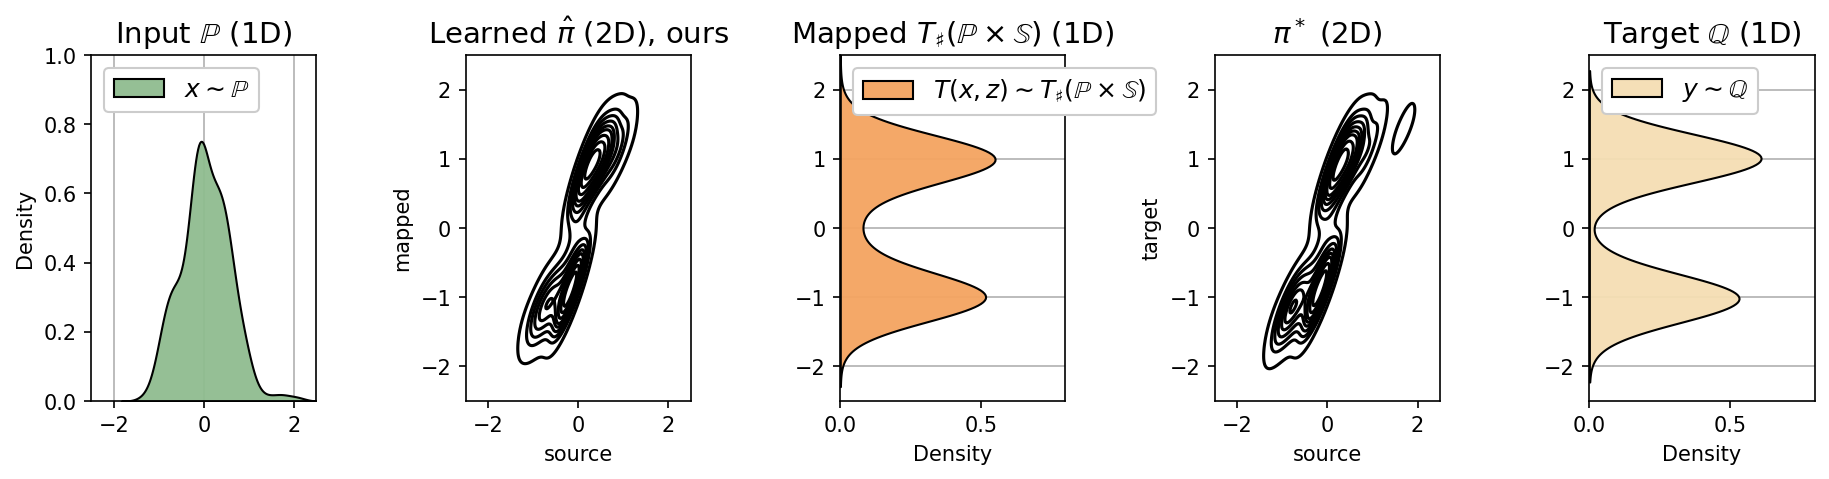

In [12]:
kg(sampler_source, sampler_target)

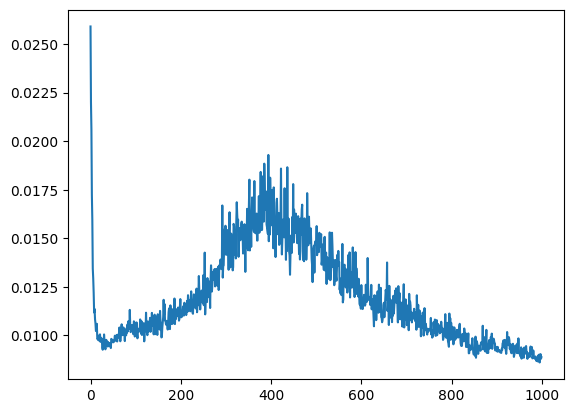

In [15]:
plt.plot(np.arange(len(kg.metrics["kant_gap"])), kg.metrics["kant_gap"])

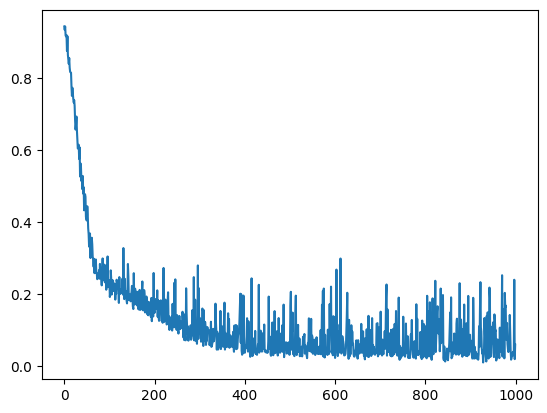

In [16]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])